In [486]:
import numpy as np
import matplotlib.pyplot as plt 

In [487]:
# to set
# k0s = np.linspace(np.pi,70*np.pi,200)

# # for k0 in k0s:
# k0 = 10 * np.pi

# # epsilon = 1E-3
# # J = 1000
# # lambdaa = 1

# # delta = 2 * epsilon**2 / lambdaa 
# # L = J * epsilon  # length of the domain # should vary
# L = 40

# nx = 300  # number of spatial points
# # nt = 35  # number of time steps

# T = 2 * (L / k0) # total time, ~ L / k0 

# # dx = L / nx # step size out of L 
# # dt = 2 * dx**2 # time step size
# dx = 0.2
# dt = 0.05

# nt = int(T / dt) # number of time steps

# print(nt)
# print(T)
# print(dt)
# print(dx)

# x = np.linspace(0, L, nx)


In [488]:
k0 = 0.5 # momentum of wave pakcket [au] (0.01 to 5)

L = 40 # length of domain 
nx = 100 # mesh points
dx = L / nx # mesh step

T = L / k0 # total time 
dt = 2 * dx**2 # time step 
nt = int(T / dt) # time points 

x = np.linspace(0, L, nx)

print(dx)
print(nt)
print(dt)

0.4
249
0.32000000000000006


In [489]:
# Gaussian wave packet
x0 = L / 4  # center of the wave packet
sigma = L / 20  # width of the wave packet
# sigma = 0.2
N = (np.pi * sigma ** 2)**(-1/4) # Normalization 
delta = T / N
gaussian = np.exp(-0.5 * ((x - x0) / sigma) ** 2)
phase = np.exp(1j * k0 * x)
psi0 = (gaussian * phase) * N # initial wave function
norm = np.sum(psi0 * np.conj(psi0)) * dx # check in psi0 is normalized
# print(norm)

In [490]:
# Potential initial conditions 
# V0 = (0.5* k0**2)  # potential strength
# V0 = 450 * np.pi**2
V0 = 1 # potential strength
# a = 0.032 # width
a = 0.2 # potential width
V = np.zeros(nx)
# start = (nx - a * nx) // 2
# end = start + a * nx
V[int((nx - a * nx) / 2):int((nx + a * nx) / 2)] = V0 # indices for start and end of the well 
print(a)
print(((nx - a * nx) / 2))


0.2
40.0


In [491]:
# Build coefficient matrix, a+
aplus = np.zeros((nx, nx),complex)
nu = 1j * dt / (4 * dx**2) # kinetic energy operator must be less than one to be stable

for i in range(len(aplus) - 1): # off diagonal 
    aplus[i,i+1] = aplus[i+1,i] = -nu 

for i in range(len(aplus)): # diagonal
    aplus[i,i] = 1 + 2 * nu 

aplus_inv = np.linalg.inv(aplus)
print(nu)


0.5j


In [492]:
# Build coefficient matrix, a-
aminus = np.zeros((nx, nx),complex)

for i in range(len(aminus)-1): # off diagonal 
    aminus[i,i+1] = aminus[i+1,i] = nu  

for i in range(len(aminus)): # diagonal
    aminus[i,i] = 1 - 2 * nu 

/var/folders/w3/12dc4l3n14zb17mtwby_trbc0000gp/T/ipykernel_29100/1512106679.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 300))


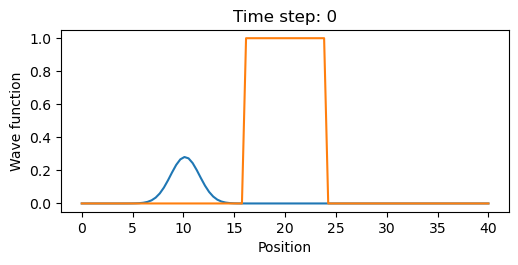

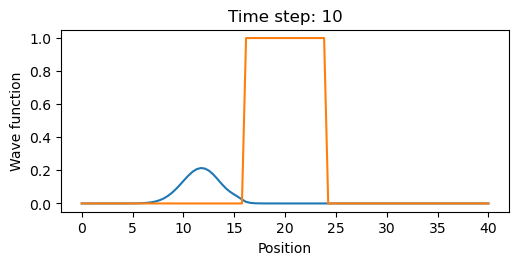

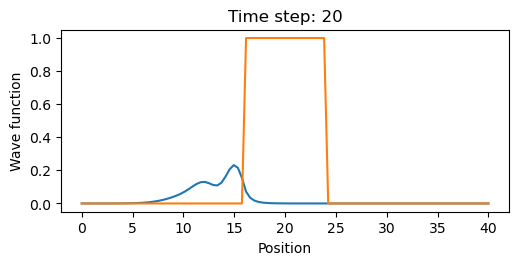

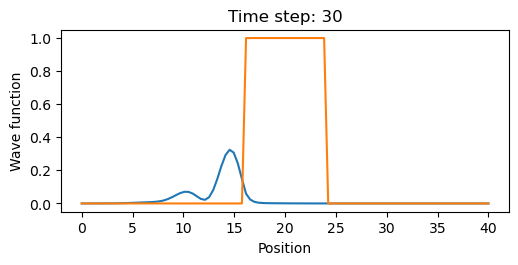

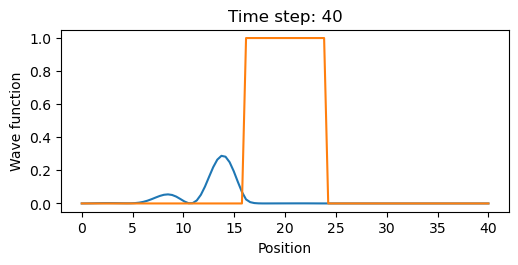

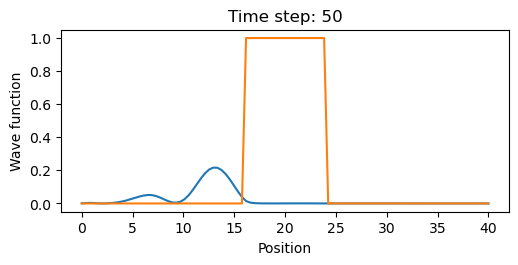

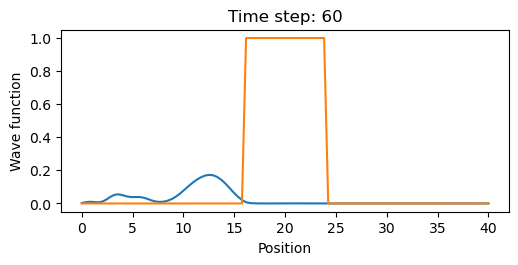

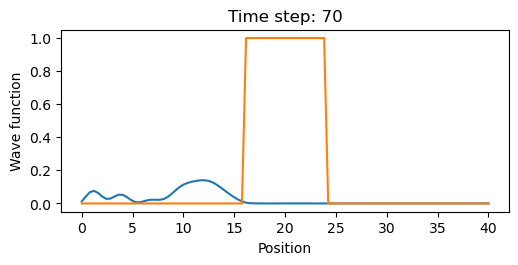

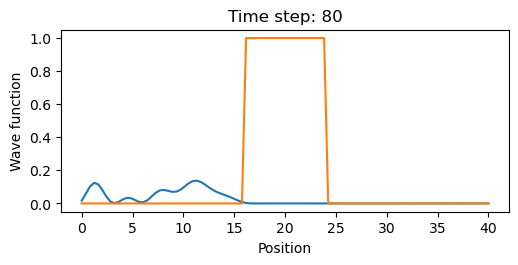

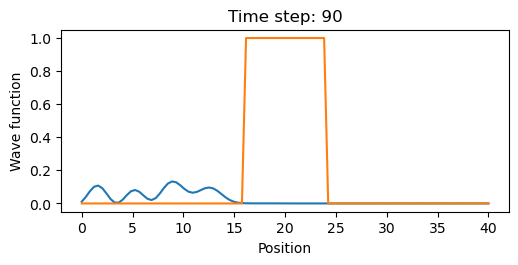

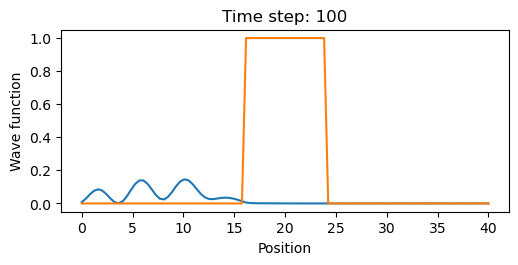

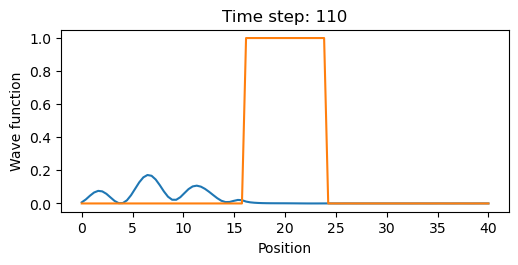

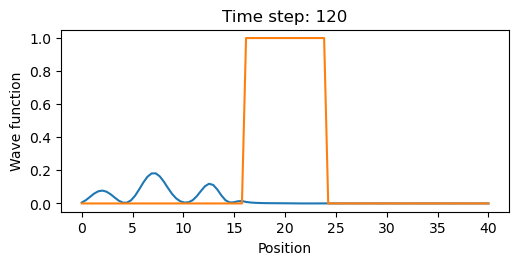

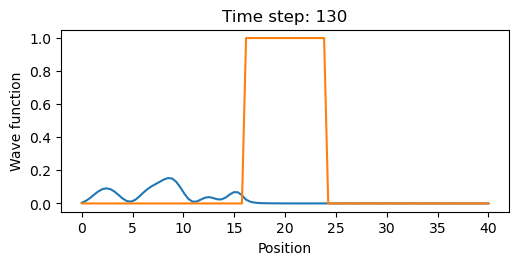

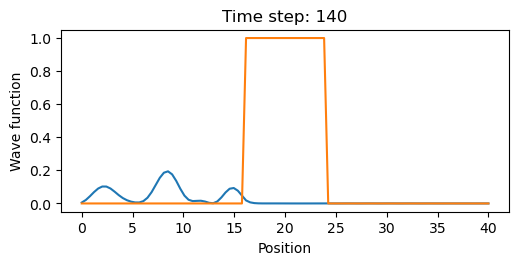

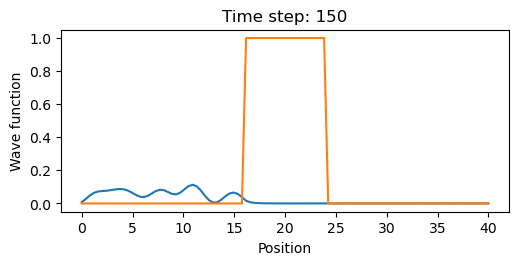

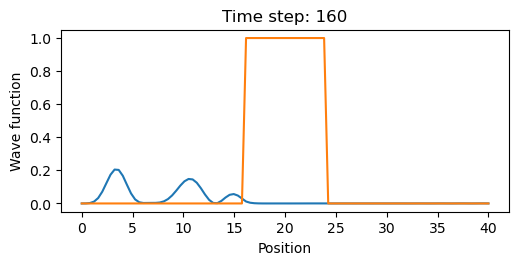

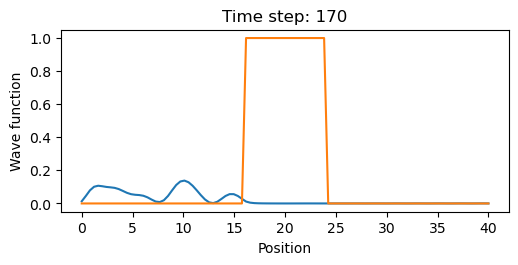

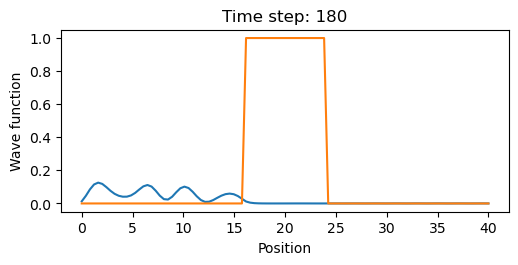

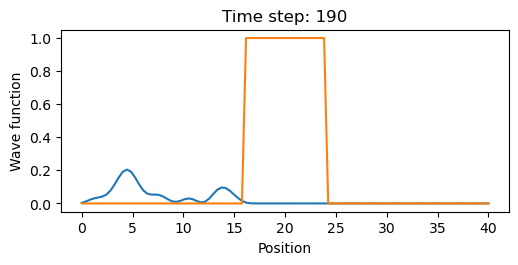

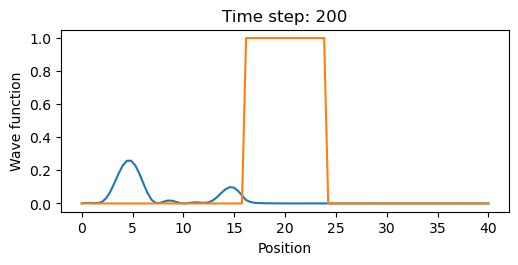

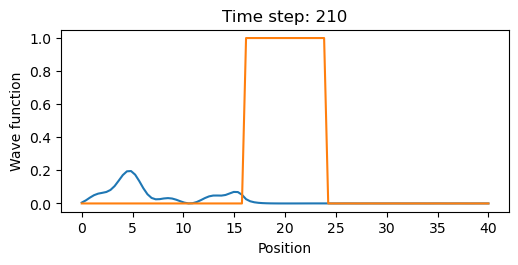

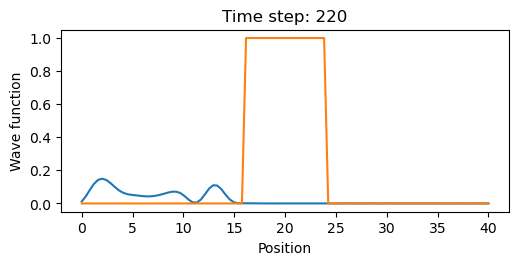

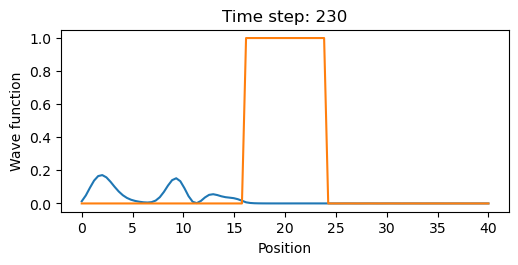

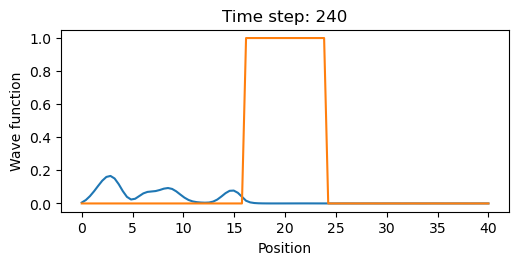

In [493]:
# Crank-Nicholson
for t in range(nt): 
    f = np.exp(-1j * dt * V) * psi0
    psi = np.dot(aplus_inv, np.dot(aminus, f))
    psi0 = psi
    
    # plotting 
    if t % 10 == 0:
        # plt.plot(x, np.abs(psi))#, label=f'Time step: {t}')
        plt.figure(figsize=(10, 300))
        num_cols = 2  # Number of columns for subplots
        num_rows = (nt + num_cols - 1) // num_cols

        plt.subplot(num_rows, num_cols, t + 1)
        plt.plot(x, np.abs(psi)**2)
        plt.plot(x, V)
        plt.title(f'Time step: {t}')
        plt.xlabel('Position')
        plt.ylabel('Wave function')
        plt.tight_layout()
    
plt.show()

# plt.plot(x, V, label='Potential (V)')
# plt.xlabel('Position')
# plt.ylabel('Wave function')
# plt.title('Gaussian wave packet scattering (TDSE w/ CN)')
# plt.legend()
# plt.show()
# print(rcoefs)


In [494]:
# Reflection and transmisison coefficients 
center = int(nx/2) # center of well

# Extract wavefunction segments for each region
reflected_wavefunction = psi[0: center] 
transmitted_wavefunction = psi[center: nx] 

# Calculate
# norm = np.sum(psi * np.conj(psi)) * dx
refl = np.sum(reflected_wavefunction * np.conj(reflected_wavefunction)) * dx
trans = np.sum(transmitted_wavefunction * np.conj(transmitted_wavefunction)) * dx

# Save
rcoefs = []
rcoefs.append(np.real(refl))
tcoefs = [] 
tcoefs.append(np.real(trans))
k0s = []
k0s.append(k0)

print(f"Reflection coefficient (R): {refl}")
print(f"Transmission coefficient (T): {trans}")
print(refl + trans)
print(norm)
print(rcoefs)
print(tcoefs)
print(k0)
print(center)
print(nx)

Reflection coefficient (R): (0.9879653346931774+0j)
Transmission coefficient (T): (0.0020346653065203887+0j)
(0.9899999999996978+0j)
(0.9899999999997745+0j)
[0.9879653346931774]
[0.0020346653065203887]
0.5
50
100


In [495]:
# # Calc R and T for time steps 
# rcoefs = []
# tcoefs = []

# for t in range(nt):
#     reflected_wavefunction = psi[0: center]
#     transmitted_wavefunction = psi[center: nx]
#     norm = np.sum(psi * np.conj(psi)) * dx

#     rcoef = np.sum(reflected_wavefunction * np.conj(reflected_wavefunction)) * dx / norm
#     rcoefs.append(rcoef)
#     tcoef = np.sum(transmitted_wavefunction * np.conj(transmitted_wavefunction)) * dx / norm
#     tcoefs.append(tcoef)



# print(rcoefs)


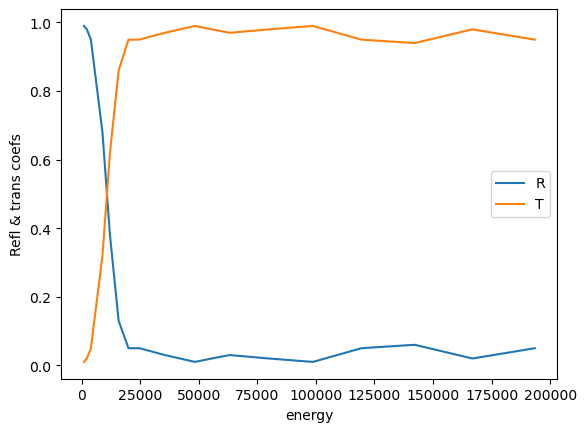

0.01


In [496]:
# Ramsauer-Townsend
k0s = [10, 15, 20, 30, 35, 40, 45, 50, 60, 70, 75, 80, 90, 100, 110, 120, 130, 140] * np.array(np.pi) 
es = k0s**2 / np.array(V0) # unitless energy 
rs = [0.99, 0.98, 0.95, 0.68, 0.38, 0.13, 0.05, 0.05, 0.03, 0.01, 0.02, 0.03, 0.02, 0.01, 0.05, 0.06, 0.02, 0.05]
ts = [0.01, 0.02, 0.05, 0.32, 0.62, 0.86, 0.95, 0.95, 0.97, 0.99, 0.98, 0.97, 0.98, 0.99, 0.95, 0.94, 0.98, 0.95]
plt.plot(es, rs, label= 'R')
plt.plot(es, ts, label = 'T')
plt.xlabel("energy")
plt.ylabel('Refl & trans coefs')
plt.title('')
plt.legend()
plt.show()
# print([k0] * nx)
print(rs[9])

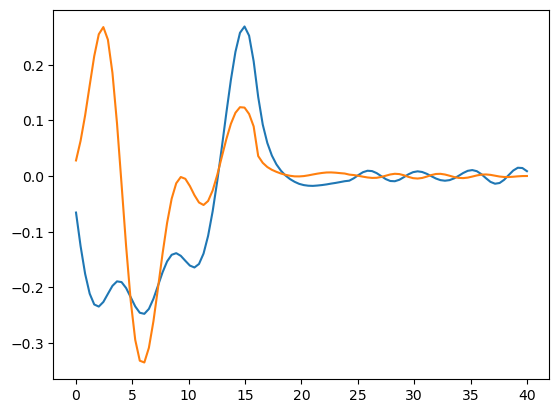

In [497]:
f = np.exp(-1j * dt * V) * psi0
# plt.plot(x, V)
plt.plot(x, f.real)
plt.plot(x, f.imag)
plt.show()